In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [2]:
spark

# Read Data

In [3]:
flightData2015 = spark\
                    .read\
                    .option("inferSchema", "true")\
                    .option("header", "true")\
                    .csv("spark-data/flight-data/csv/2015-summary.csv")

In [4]:
flightData2015.take(3)

[Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Romania', count=15),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Croatia', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Ireland', count=344)]

### Sort does not modify the DataFrame. We use sort as a transformation that returns a new DataFrame by transforming the previous DataFrame.

In [5]:
flightData2015.sort("count")

DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: int]

### However, we can see that Spark is building up a plan for how it will execute this across the cluster by looking at the explain plan.

In [6]:
flightData2015.sort("count").explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [count#19 ASC NULLS FIRST], true, 0
   +- Exchange rangepartitioning(count#19 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [plan_id=33]
      +- FileScan csv [DEST_COUNTRY_NAME#17,ORIGIN_COUNTRY_NAME#18,count#19] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/home/jovyan/work/files/spark-data/flight-data/csv/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,ORIGIN_COUNTRY_NAME:string,count:int>




# Perform Action

In [7]:
flightData2015.sort("count").take(10)

[Row(DEST_COUNTRY_NAME='Suriname', ORIGIN_COUNTRY_NAME='United States', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Estonia', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Cyprus', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Croatia', count=1),
 Row(DEST_COUNTRY_NAME='Zambia', ORIGIN_COUNTRY_NAME='United States', count=1),
 Row(DEST_COUNTRY_NAME='Moldova', ORIGIN_COUNTRY_NAME='United States', count=1),
 Row(DEST_COUNTRY_NAME='Burkina Faso', ORIGIN_COUNTRY_NAME='United States', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Gibraltar', count=1),
 Row(DEST_COUNTRY_NAME='Djibouti', ORIGIN_COUNTRY_NAME='United States', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Singapore', count=1)]

In [8]:
flightData2015.sort("count").show()

+--------------------+-------------------+-----+
|   DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+--------------------+-------------------+-----+
|       United States|            Estonia|    1|
|              Kosovo|      United States|    1|
|              Zambia|      United States|    1|
|       United States|   Papua New Guinea|    1|
|               Malta|      United States|    1|
|       United States|          Gibraltar|    1|
|            Suriname|      United States|    1|
|       United States|            Croatia|    1|
|            Djibouti|      United States|    1|
|        Burkina Faso|      United States|    1|
|Saint Vincent and...|      United States|    1|
|       United States|             Cyprus|    1|
|       United States|          Singapore|    1|
|             Moldova|      United States|    1|
|              Cyprus|      United States|    1|
|       United States|          Lithuania|    1|
|       United States|           Bulgaria|    1|
|       United State

# DataFrame and SQL

## Create Table

In [9]:
flightData2015.createOrReplaceTempView("flightData2015")

## Query the data in SQL

In [10]:
sqlWay = spark.sql("""
    SELECT DEST_COUNTRY_NAME, count(1)
    FROM flightData2015
    GROUP BY DEST_COUNTRY_NAME
    """)

In [11]:
sqlWay.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[DEST_COUNTRY_NAME#17], functions=[count(1)])
   +- Exchange hashpartitioning(DEST_COUNTRY_NAME#17, 200), ENSURE_REQUIREMENTS, [plan_id=61]
      +- HashAggregate(keys=[DEST_COUNTRY_NAME#17], functions=[partial_count(1)])
         +- FileScan csv [DEST_COUNTRY_NAME#17] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/home/jovyan/work/files/spark-data/flight-data/csv/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string>




### Same logic via DataFrame

In [12]:
dataFrameWay = flightData2015\
                .groupBy("DEST_COUNTRY_NAME")\
                .count() 

In [13]:
dataFrameWay.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[DEST_COUNTRY_NAME#17], functions=[count(1)])
   +- Exchange hashpartitioning(DEST_COUNTRY_NAME#17, 200), ENSURE_REQUIREMENTS, [plan_id=74]
      +- HashAggregate(keys=[DEST_COUNTRY_NAME#17], functions=[partial_count(1)])
         +- FileScan csv [DEST_COUNTRY_NAME#17] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/home/jovyan/work/files/spark-data/flight-data/csv/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string>




In [14]:
spark.sql("SELECT max(count) FROM flightData2015").take(1)

[Row(max(count)=370002)]

In [15]:
from pyspark.sql.functions import max
flightData2015.select(max("count")).take(1)

[Row(max(count)=370002)]

In [16]:
  maxSql = spark.sql("""
  SELECT DEST_COUNTRY_NAME, sum(count) as destination_total
  FROM flightData2015
  GROUP BY DEST_COUNTRY_NAME
  ORDER BY sum(count) DESC
  LIMIT 5
  """)

In [17]:
maxSql.show()

+-----------------+-----------------+
|DEST_COUNTRY_NAME|destination_total|
+-----------------+-----------------+
|    United States|           411352|
|           Canada|             8399|
|           Mexico|             7140|
|   United Kingdom|             2025|
|            Japan|             1548|
+-----------------+-----------------+



In [18]:
from pyspark.sql.functions import desc

flightData2015\
    .groupBy("DEST_COUNTRY_NAME")\
    .sum("count")\
    .withColumnRenamed("sum(count)", "destination_total")\
    .sort(desc("destination_total"))\
    .limit(5)\
    .show()

+-----------------+-----------------+
|DEST_COUNTRY_NAME|destination_total|
+-----------------+-----------------+
|    United States|           411352|
|           Canada|             8399|
|           Mexico|             7140|
|   United Kingdom|             2025|
|            Japan|             1548|
+-----------------+-----------------+



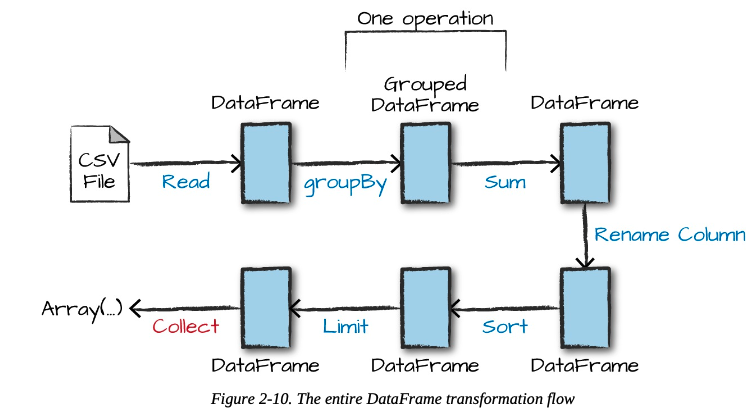